## 13. Crime

In this notebook we will explore the Victoria Police Department's [crime stats](https://www.crimereports.com/agency/vicpdcanada).

To harvest the data we go to the primary webpage [crime reports](http://www.crimereports.com) and click on data.

Notice the file is over **100Mb**.  Please **do not** copy this into your personal **mp248** repo.  When you use this data for Homework Assignment 4, please load the file from the **course repo**. 

In [1]:
import json

with open("data/Victoria (BC) Police Department.geojson") as f:
    data = json.loads(f.read())

In [2]:
print(type(data))
print(data.keys())
print(data['type'])
print(len(data['features']))
## okay, the data is basically a big list of all police records
print(data['features'][2])

<class 'dict'>
dict_keys(['type', 'features'])
FeatureCollection
129095
{'type': 'Feature', 'properties': {'city': 'VICTORIA', 'latitude': '48.4212191967164', 'parent_incident_type': 'Alarm', 'zip': None, 'state': 'BC', 'day_of_week': 'Saturday', 'incident_id': '630184524', 'clearance_type': '', 'incident_description': 'Please <a href="http://www.vicpd.ca/public-information/crimereports/crimereports-disclaimer.aspx" target="_blank">click here</a> to view our disclaimer.', 'country': None, 'longitude': '-123.381891254424', 'address_2': None, 'hour_of_day': '21', 'created_at': '2014-12-07T13:03:34.000', 'address_1': 'MICHIGAN ST & ST LAWRENCE ST', 'incident_type_primary': 'FALSE ALARMS', 'updated_at': '2015-01-04T20:40:34.000', 'case_number': '14-54570', 'incident_datetime': '2014-12-06T21:59:00.000'}, 'geometry': {'type': 'Point', 'coordinates': [-123.381891254424, 48.4212191967164]}}


## First off

Let's build a dictionary that keeps track of what kind of data is reported.  As we can see from the dictionary, there is a **parent_incident_type**, and an **incident_type_primary**.  It would appear *incident_type_primary* is a more detailed break-down of the *parent_incident_type* so this data would appear to fit in a tree structure.

## Let's build the tree...

of the types of crime records in the database. We might as well count the number of each record type while we're at it.

In [3]:
import collections as co
import pprint as pp

ctree = dict()

for R in data['features']:
    #print(R)
    #print('.',end='', flush=True)
    TopI = R['properties']['parent_incident_type']
    BotI = R['properties']['incident_type_primary']
    if TopI not in ctree.keys():
        ctree[TopI] = co.defaultdict(int)
    ctree[TopI][BotI] += 1
    
pp.pprint(ctree)

{'Alarm': defaultdict(<class 'int'>, {'FALSE ALARMS': 1447}),
 'Arson': defaultdict(<class 'int'>,
                      {'ARSON-DISREGARD FOR HUMAN LIFE': 22,
                       'ARSON-PROPERTY': 260}),
 'Assault': defaultdict(<class 'int'>,
                        {'ASSAULT AGAINST POLICE OFFICER': 417,
                         'ASSAULT-COMMON OR TRESPASS': 2065,
                         'ASSAULTS-OTHER': 473}),
 'Assault with Deadly Weapon': defaultdict(<class 'int'>,
                                           {'ASSAULT OT P/O-W/WPN OR CBH': 38,
                                            'ASSAULT POLICE-W/WEAPON OR CBH': 75,
                                            'ASSAULT-AGGRAVATED': 98,
                                            'ASSAULT-OTHER PEACE OFFICER': 125,
                                            'ASSAULT-W/WEAPON OR CBH': 1552}),
 'Breaking & Entering': defaultdict(<class 'int'>,
                                    {'BREAK & ENTER-BUSINESS': 1691,
          

## Pie charts

Let's write some code that turns the above tree data into pie charts.  I.e. we want to plot the relative frequency of the various crime types.

Let's start with the **parent_incident_types**.

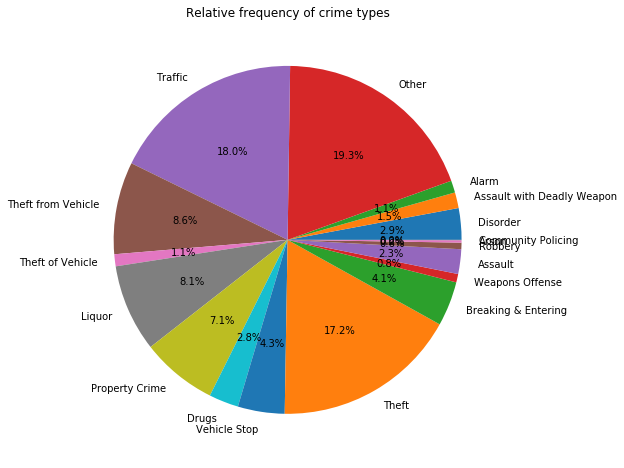

In [4]:
parent_counts = [sum(v.values()) for k,v in ctree.items()]
parent_names = [k for k,v in ctree.items()]

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,8))
plt.title("Relative frequency of crime types")
X = plt.pie(parent_counts, labels=parent_names, autopct='%1.1f%%')

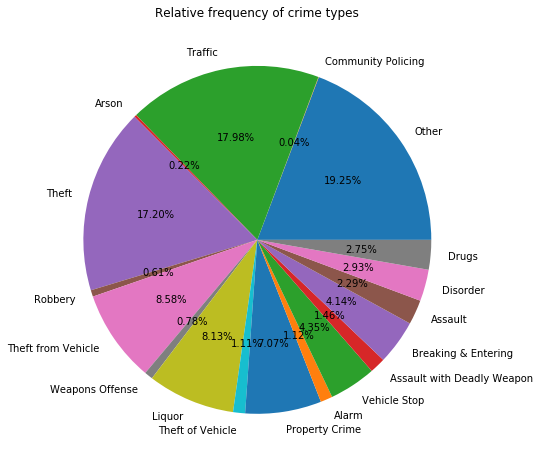

In [5]:
## let's see if we can fix that output to be more readable. 
import operator as op

parent_counts = [(k, sum(v.values())) for k,v in ctree.items()]
parent_counts.sort(key=op.itemgetter(1))

shuffle_counts = []
while parent_counts:
    if len(parent_counts)%2 == 0:
        shuffle_counts.append(parent_counts.pop())
    else:
        shuffle_counts.append(parent_counts.pop(0))
        
plt.figure(figsize=(8,8))
plt.title("Relative frequency of crime types")
X = plt.pie([x[1] for x in shuffle_counts], labels=[x[0] for x in shuffle_counts], autopct='%1.2f%%')

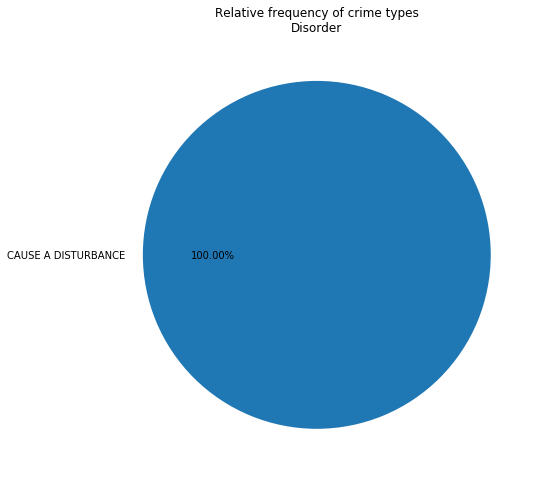

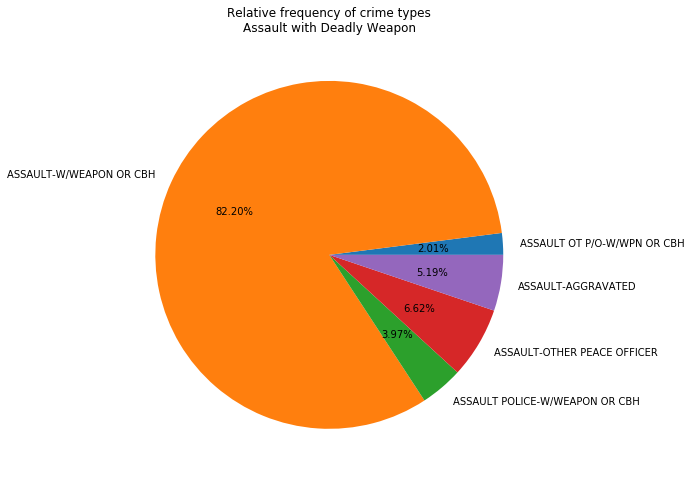

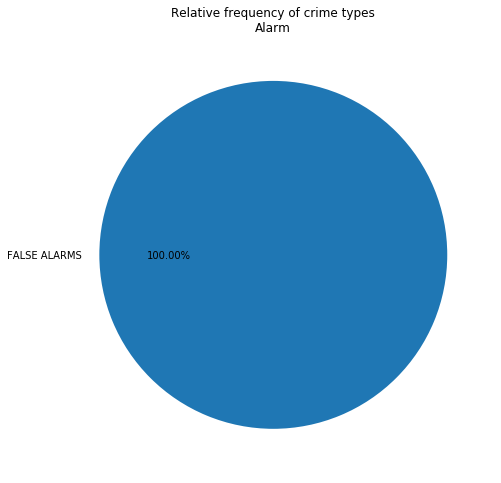

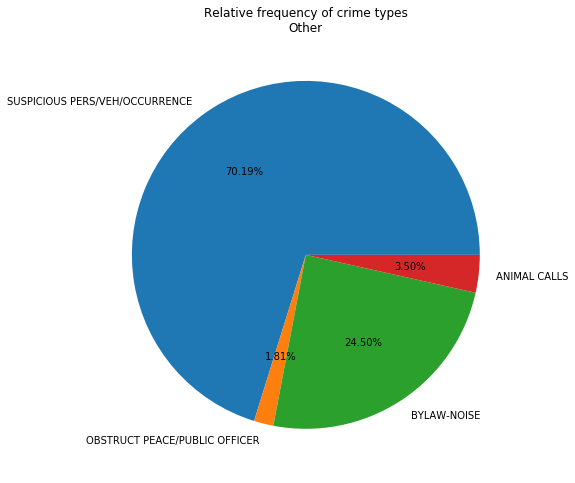

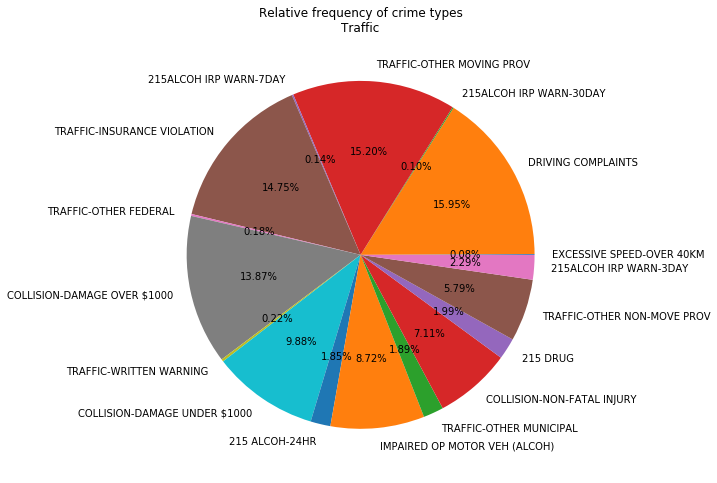

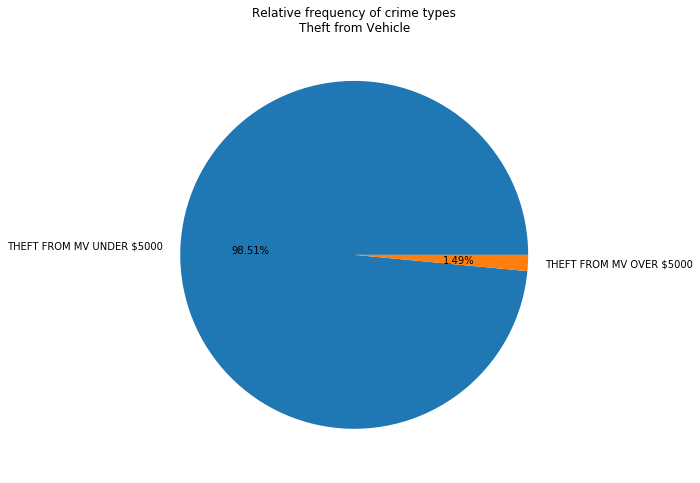

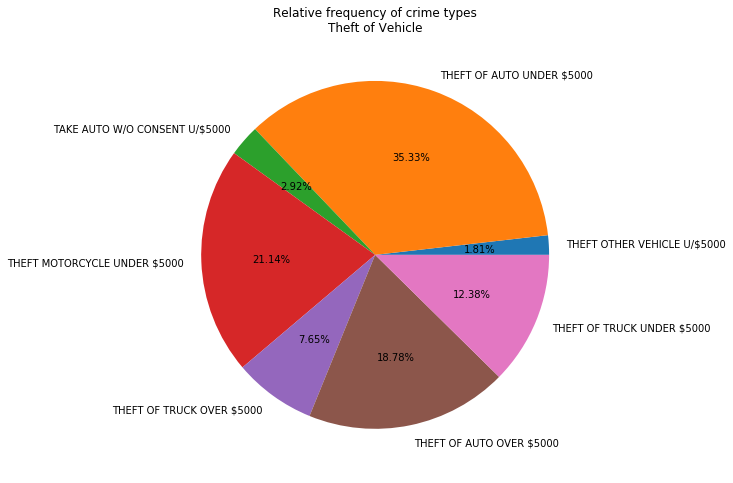

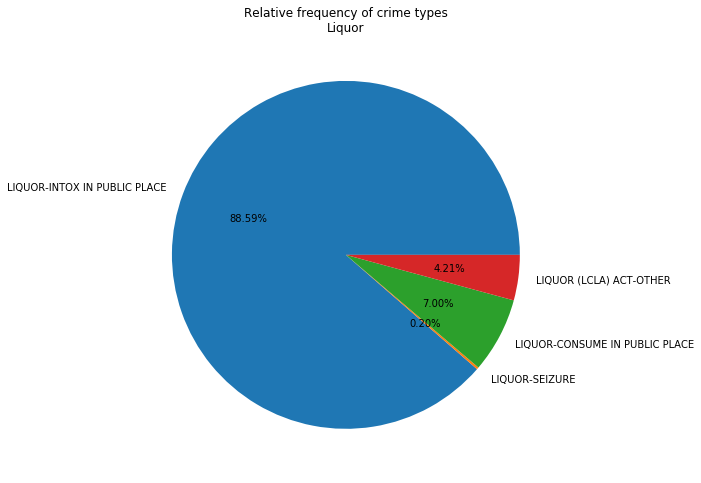

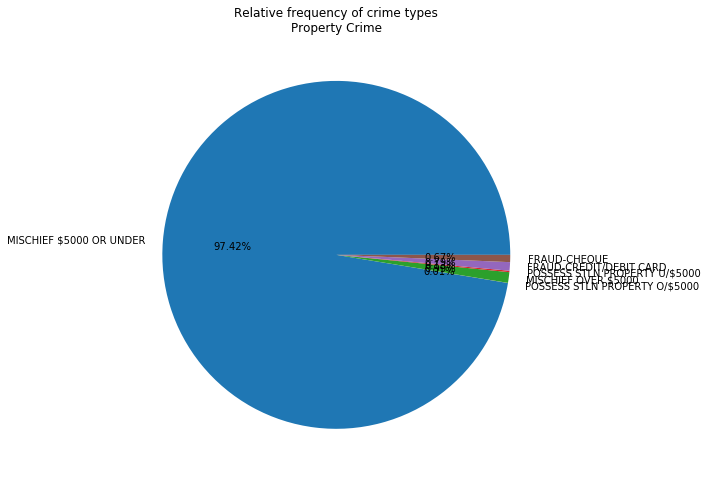

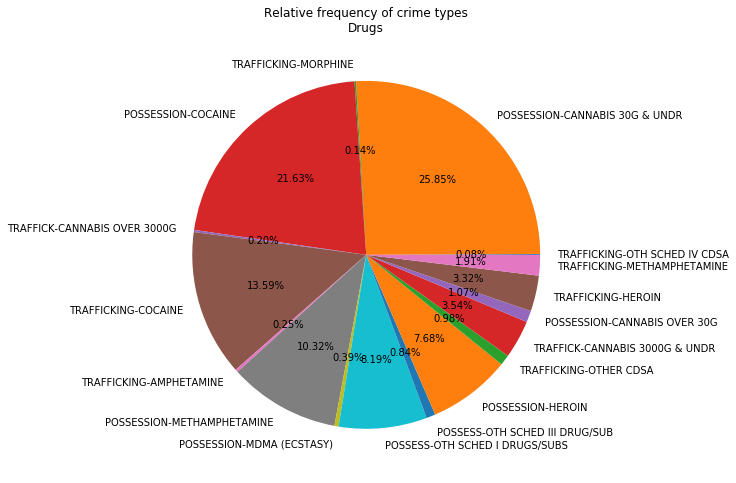

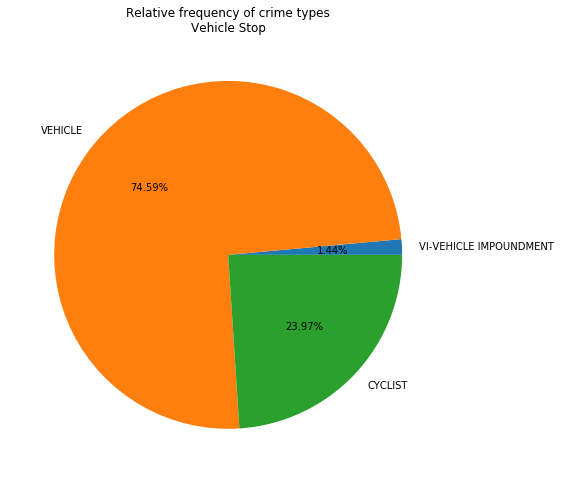

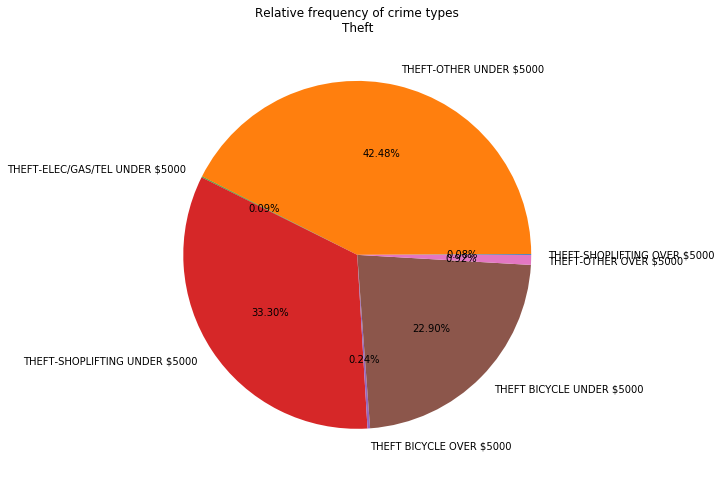

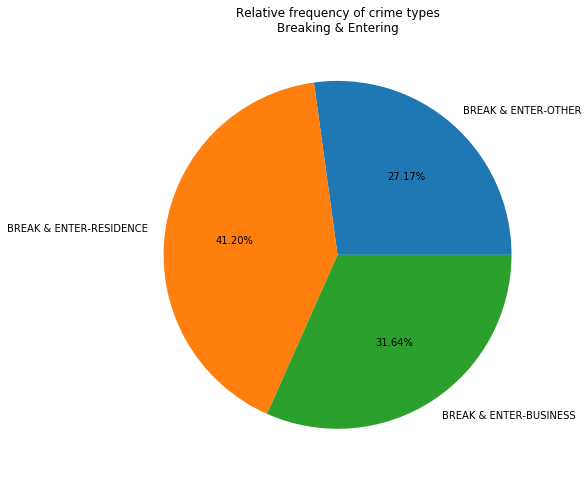

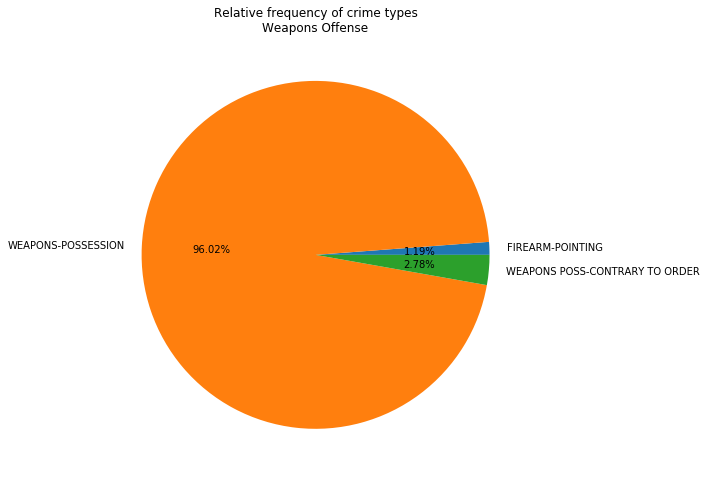

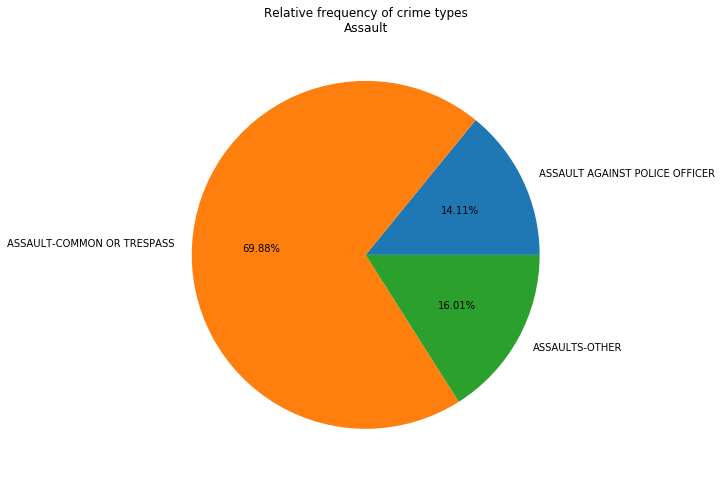

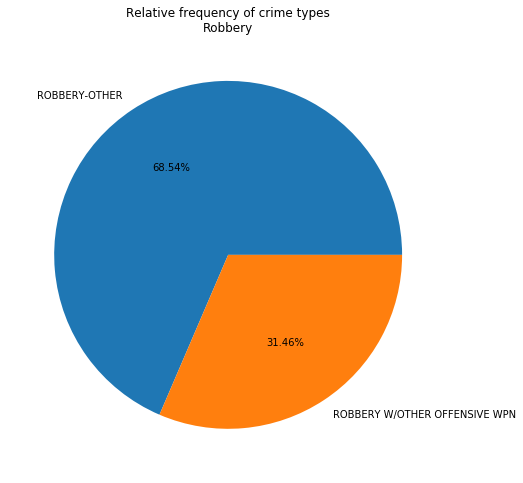

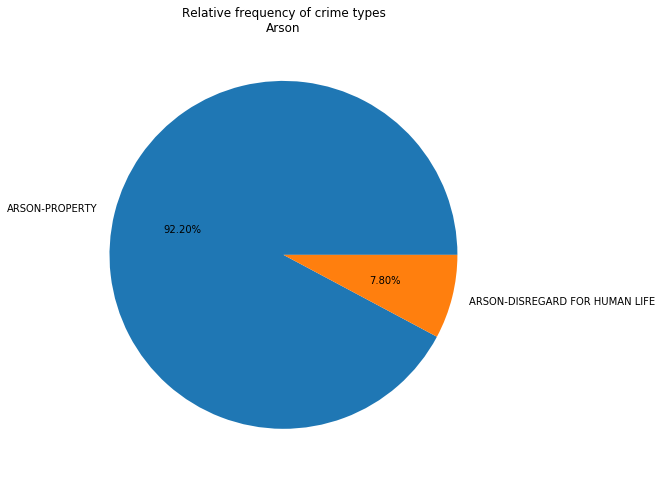

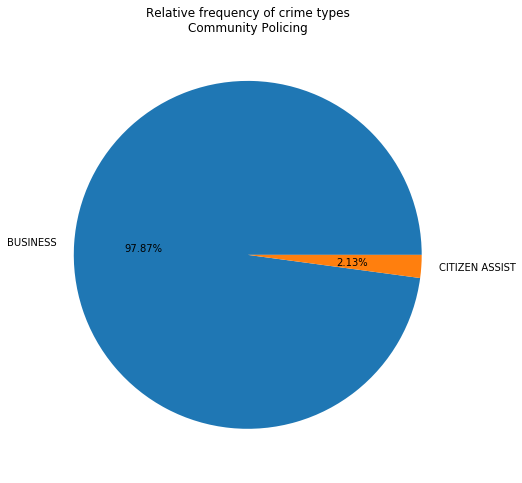

In [6]:
## and let's make a routine that makes a piechart for the incident_type_primary
## sub-crimes of a given parent_incident_type

## given a parent incident type, this routine plots a pie chart of the
## relative frequency of the incident_type_primary associated
def primary_pie(pit):
    if pit not in ctree.keys():
        print("Argument must be from ctree.keys()")
        print(ctree.keys())
        return(0)
    
    parent_counts = list(ctree[pit].items())
    parent_counts.sort(key=op.itemgetter(1))

    shuffle_counts = []
    while parent_counts:
        if len(parent_counts)%2 == 0:
            shuffle_counts.append(parent_counts.pop())
        else:
            shuffle_counts.append(parent_counts.pop(0))

    plt.figure(figsize=(8,8))
    plt.title("Relative frequency of crime types\n"+pit)
    X = plt.pie([x[1] for x in shuffle_counts], labels=[x[0] for x in shuffle_counts], autopct='%1.2f%%')
    
for k in ctree.keys():
    primary_pie(k)


## Clean up the data

To start with let's convert the numbers to appropriate **float** and **int** data types. Convert the dates to **datetime** objects.

Recall **data['features']** is a list, and this dictionary is the list element evaluated at **'properties'**.


In [7]:
import datetime as dt

clean_dat = list()
incompl_dat = list()

for x in data['features']:
    if 'properties' not in x.keys():
        continue ## why bother?

    ## we have the properties, so let's start building the record.
    newRec = dict()
    incFlag = False # set to true if we discover missing data in x
    
    floatkeys = ['latitude', 'longitude']
    strkeys = ['parent_incident_type', 'incident_type_primary', 'address_1', 'address_2']
    intkeys = ['case_number', 'incident_id']
    datekeys = ['created_at', 'updated_at', 'incident_datetime']
    
    for k in floatkeys:
        if k in x['properties'].keys() and isinstance(x['properties'][k], str) and\
        len(x['properties'][k])>0:
            newRec[k] = float(x['properties'][k])
        else:
            incFlag=True

    ## anything to check?
    for k in strkeys:
        newRec[k] = x['properties'][k]
        
    for k in intkeys:
        ## let's count non-numerical characters
        non_ch_chars = []
        digits = '0123456789'
        for ch in x['properties'][k]:
            if ch not in digits:
                non_ch_chars.append(ch)

        for ch in non_ch_chars:
            if ch != '-':
                x['properties'][k] = x['properties'][k].replace(ch, '-')
            
        if '-' in x['properties'][k]:
            newRec[k] = [int(w) for w in x['properties'][k].split('-')]
        else:
            newRec[k] = int(x['properties'][k])
            
    for k in datekeys:
        ## typical format: '2014-12-06T21:59:00.000'
        newRec[k] = dt.datetime.strptime(x['properties'][k], '%Y-%m-%dT%H:%M:%S.000')
        
    if incFlag:
        incompl_dat.append(newRec)
    else:
        clean_dat.append(newRec)


In [8]:
print(len(incompl_dat), len(clean_dat))

1 129094


In [9]:
print(incompl_dat)

[{'parent_incident_type': 'Drugs', 'incident_type_primary': 'POSSESSION-METHAMPHETAMINE', 'address_1': None, 'address_2': None, 'case_number': [16, 42790], 'incident_id': 773865128, 'created_at': datetime.datetime(2016, 9, 24, 10, 2, 9), 'updated_at': datetime.datetime(2016, 10, 18, 19, 40, 55), 'incident_datetime': datetime.datetime(2016, 9, 19, 20, 42)}]


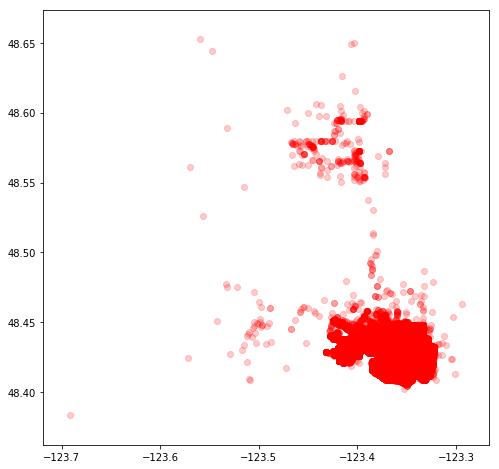

In [11]:
## Let's try a matplotlib plot of the GPS coordinates.
X=[]
Y=[]
eg0=[]
for x in clean_dat:
    if x['latitude'] > 48.655 or x['latitude'] < 48:
        eg0.append(x)
        continue
    if x['longitude']<-124 or x['longitude']>-123:
        eg0.append(x)
        continue
    X.append(x['longitude'])
    Y.append(x['latitude'])

plt.figure(figsize=(8,8))
plt.scatter(X, Y, color='r', alpha=0.2)

## okay it looks like we might have some erroneous coordinates.

In [ ]:
pp.pprint(eg0)

In [ ]:
## lets run through the data and check the three timestamps
## incident_datetime, created_at, updated_at
## are appear in that relative order

eg1 = []
eg2 = []
for x in clean_dat:
    if x['incident_datetime'] > x['created_at']:
        eg1.append(x)
    if x['updated_at'] < x['created_at']:
        eg2.append(x)
        
print("Incidents occur after record created: ", len(eg1))
print("Incident updated before record created: ", len(eg2))

In [15]:
## if we wanted to purge the bad records we could rewrite clean_dat like this:
print(len(clean_dat))

clean_dat = [x for x in clean_dat if x not in eg0]

print(len(clean_dat), len(clean_dat)+len(eg0))

129094
129029 129094


## put data in library

Let's push all this code into a library.